In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [5]:
from torchvision import datasets, transforms

# すでに展開済みのCIFAR-10データの保存先を明示
data_path = "../data-unversioned/p1ch7"

# download=False にして、既存データを使う
cifar10 = datasets.CIFAR10(
    root=data_path,
    train=True,
    download=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

In [6]:
cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616)),
        ]
    ),
)

In [7]:
label_map = {0: 0, 2: 1}
class_names = ["airplane", "bird"]
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [8]:
connected_model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
)

In [9]:
numel_list = [
    p.numel()  # 各パラメータテンソルの要素数（たとえば重み行列の総数）
    for p in connected_model.parameters()  # 全てのパラメータをループ
    if p.requires_grad == True  # 勾配計算対象（学習対象）パラメータのみ
]

sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [10]:
first_model = nn.Sequential(
    nn.Linear(3072, 512), nn.Tanh(), nn.Linear(512, 2), nn.LogSoftmax(dim=1)
)

In [11]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [12]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [13]:
# 畳み込み層（Conv2d）を定義する
# 入力チャンネル数: 3（例：RGB画像）
# 出力チャンネル数: 16（16個の畳み込みフィルターを使用）
# カーネルサイズ: 3（3x3の畳み込みフィルター）
# ストライド: デフォルトは1（1ピクセルずつスライド）
# パディング: デフォルトは0（ゼロパディングなし）
# バイアス: デフォルトでTrue（各出力チャンネルにバイアス項あり）
conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3)

# 層の構成情報を出力（確認用）
print(conv)

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))


In [14]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [15]:
# cifar2 データセットから1枚目の画像とラベルを取得（ここではラベルは使用しない）
img, _ = cifar2[0]

# Conv2d層は入力にミニバッチ次元が必要なため、unsqueeze(0) で1つ次元を追加して [1, 3, 32, 32] に変換
# img の元の形状は [3, 32, 32]（チャンネル, 高さ, 幅）
output = conv(img.unsqueeze(0))

# 入力画像の shape（[1, 3, 32, 32]）と、conv を通した出力の shape を表示
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

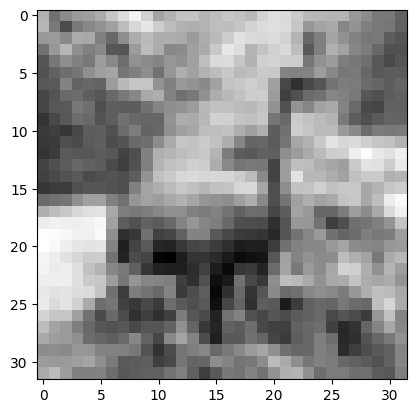

In [16]:
plt.imshow(img.mean(0), cmap="gray")
plt.show()

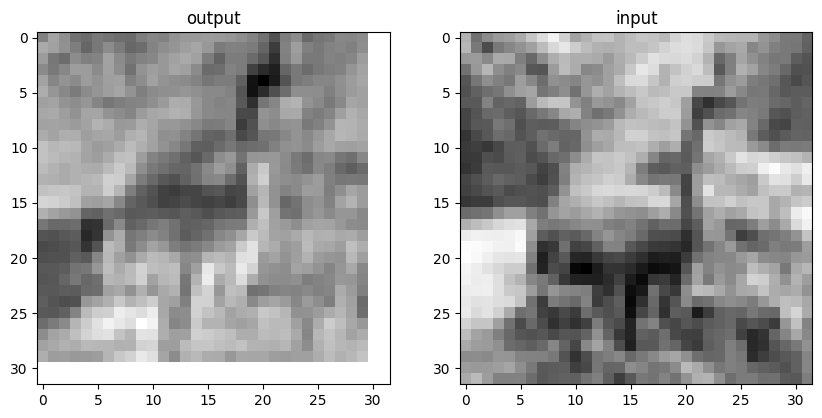

In [17]:
# 出力と入力画像を並べて比較するためのプロット設定（横2枚）
plt.figure(figsize=(10, 4.8))  # 図全体のサイズを設定（本では省略されている）

# 左側に出力特徴マップ（Conv2Dの出力）を表示
ax1 = plt.subplot(1, 2, 1)  # 左側のサブプロット（1行2列の1つ目）
plt.title("output")  # タイトルを設定
plt.imshow(
    output[0, 0].detach(), cmap="gray"
)  # バッチ0・チャネル0の出力をグレースケールで表示（detachで計算グラフから切り離し）

# 右側に元の入力画像（平均化したもの）を表示
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # 左とx, y軸を共有
plt.imshow(
    img.mean(0), cmap="gray"
)  # 入力画像をチャネル方向に平均してグレースケール表示
plt.title("input")  # タイトルを設定

# 図をPNG画像として保存（本では省略されている）
plt.savefig("Ch8_F2_PyTorch.png")

# 表示
plt.show()